In [ ]:
# 쿠팡 직무 대비: 카탈로그 데이터 정제·패턴 탐지 프로젝트

- 데이터: 한국농수산식품유통공사_가공식품 소매가격 정보_20250826.csv
- 목적:
  1. 상품명(품종)의 텍스트 패턴 분석
  2. 카탈로그 이상 패턴(규격 누락, 단위 없음 등) 탐지
  3. 가격 시계열 기반 이상 가격 탐지

이 노트북은 이직 포트폴리오 제출용으로 작성되었습니다.
쿠팡 카탈로그 데이터에 동일한 로직을 적용할 수 있는 형태로 구성하는 것을 목표로 합니다.


In [3]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [4]:
df = pd.read_csv("c:/Users/soule/Downloads/한국농수산식품유통공사_가공식품_소매가격_정보_20250826.csv")
df.head()


,조사일,품목부류,품목,품종,등급,단위,평균가,최저가,최고가
0,2023-01-02,식품,간장,샘표 양조간장 501 1.7L,상품,1개,12364.667,10701,13694
1,2023-01-02,식품,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,상품,1개,17486.667,5540,18300
2,2023-01-02,식품,김치,대상 종가집 포기김치 3.3kg,상품,1개,33833.704,33790,34800
3,2023-01-02,식품,된장,청정원 재래식 생된장 1kg,상품,1개,7952.963,4980,8190
4,2023-01-02,식품,두부,풀무원 국산콩 300g×2,상품,1개,5287.826,4780,5480


In [5]:
print("데이터 크기:", df.shape)
print("\n컬럼 목록:", df.columns.tolist())
print("\ninfo():")
print(df.info())

print("\n결측치 개수:")
print(df.isna().sum())


데이터 크기: (5094, 9)

컬럼 목록: ['조사일', '품목부류', '품목', '품종', '등급', '단위', '평균가', '최저가', '최고가']

info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5094 entries, 0 to 5093
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   조사일     5094 non-null   object 
 1   품목부류    5094 non-null   object 
 2   품목      5094 non-null   object 
 3   품종      5094 non-null   object 
 4   등급      5094 non-null   object 
 5   단위      5094 non-null   object 
 6   평균가     5094 non-null   float64
 7   최저가     5094 non-null   int64  
 8   최고가     5094 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 358.3+ KB
None

결측치 개수:
조사일     0
품목부류    0
품목      0
품종      0
등급      0
단위      0
평균가     0
최저가     0
최고가     0
dtype: int64


In [6]:
# 조사일 → datetime 변환
df["조사일"] = pd.to_datetime(df["조사일"])

print("조사 기간:", df["조사일"].min(), "~", df["조사일"].max())
print("\n품목 목록:", df["품목"].unique())
print("\n품종(상품명) 개수:", df["품종"].nunique())

# 품목·품종별 가격 요약
summary = (
    df.groupby(["품목", "품종"])[["평균가", "최저가", "최고가"]]
      .agg(["mean", "min", "max"])
      .round(1)
)
summary


조사 기간: 2023-01-02 00:00:00 ~ 2025-08-26 00:00:00

품목 목록: ['간장' '고추장' '김치' '된장' '두부' '맛김(조미김)' '즉석밥' '콩나물']

품종(상품명) 개수: 9


평균가                        최저가         \
                                  mean      min      max     mean    min   
품목      품종                                                                 
간장      샘표 양조간장 501 1.7L       12895.2   9263.7  14860.6   9693.1   6370   
고추장     해찬들 우리쌀로만든 태양초고추장 1kg  15726.7  10782.9  19200.0   8426.0   4980   
김치      대상 종가집 포기김치 2.8kg      29690.9  29296.8  30112.5  26117.1  19900   
        대상 종가집 포기김치 3.3kg      33347.7  30867.0  35781.8  27918.2      0   
된장      청정원 재래식 생된장 1kg         7559.1   5290.6   9325.0   4591.1   3280   
두부      풀무원 국산콩 300g×2          5277.0   4921.2   5503.0   4118.4   2740   
맛김(조미김) 동원에프앤비 양반 들기름김 5g×20봉   9182.1   7150.7  10851.8   6668.1   4900   
즉석밥     CJ 햇반 백미밥 210g×8개      10153.9   8492.5  10905.9   8118.2   5480   
콩나물     풀무원 국산콩 콩나물 340g        2479.3   1959.4   3240.0   2141.2   1300   

                                          최고가                
                                 max     mean    min    max  
품목      품종                                                   
간장      샘표 양조간장 501 1.7L       13411  15033.1  12070  17500  
고추장     해찬들 우리쌀로만든 태양초고추장 1kg  19200  20474.5  17960  23900  
김치      대상 종가집 포기김치 2.8kg      29800  30838.5  29800  31300  
        대상 종가집 포기김치 3.3kg      33790  34379.6  33800  38900  
된장      청정원 재래식 생된장 1kg         9100   9305.7   8190  10980  
두부      풀무원 국산콩 300g×2          5220   5576.5   5290   5980  
맛김(조미김) 동원에프앤비 양반 들기름김 5g×20봉   8860  11213.9   8980  16600  
즉석밥     CJ 햇반 백미밥 210g×8개      10900  11225.7   9980  12900  
콩나물     풀무원 국산콩 콩나물 340g        2590   3196.5   2680  23400

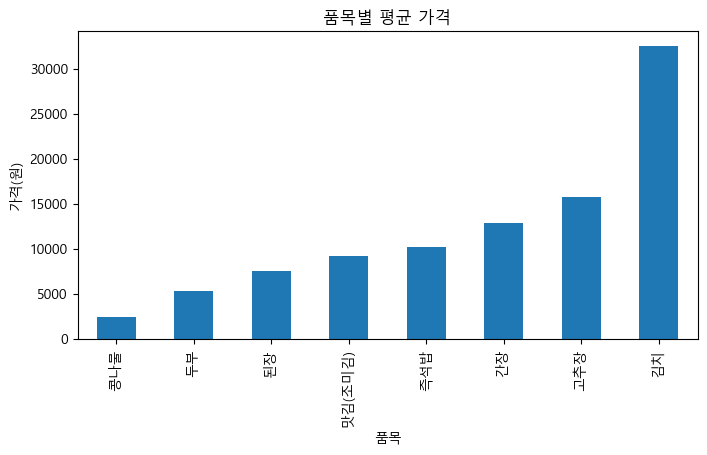

In [7]:
# 품목별 평균 가격 비교 예시
mean_price_by_item = (
    df.groupby("품목")["평균가"]
      .mean()
      .sort_values()
)

mean_price_by_item.plot(kind="bar", figsize=(8,4))
plt.title("품목별 평균 가격")
plt.ylabel("가격(원)")
plt.show()


In [8]:
# 품종(상품명)을 기준으로 텍스트 특성 추출
df["품종"] = df["품종"].astype(str)

df["name"] = df["품종"]
df["name_len"] = df["name"].str.len()
df["digit_cnt"] = df["name"].str.count(r"\d")
df["unit_flag"] = df["name"].str.contains("g|kg|ml|mL|L|ℓ|리터|봉|개|입|포기", regex=True).astype(int)

df[["품목", "품종", "name_len", "digit_cnt", "unit_flag"]].head(10)


,품목,품종,name_len,digit_cnt,unit_flag
0,간장,샘표 양조간장 501 1.7L,16,5,1
1,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
2,김치,대상 종가집 포기김치 3.3kg,17,2,1
3,된장,청정원 재래식 생된장 1kg,15,1,1
4,두부,풀무원 국산콩 300g×2,14,4,1
5,맛김(조미김),동원에프앤비 양반 들기름김 5g×20봉,21,3,1
6,즉석밥,CJ 햇반 백미밥 210g×8개,17,4,1
7,콩나물,풀무원 국산콩 콩나물 340g,16,3,1
8,간장,샘표 양조간장 501 1.7L,16,5,1
9,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1


In [9]:
# 품종 수준으로 중복 제거(같은 상품이 여러 일자에 반복 등장하므로)
name_df = df[["품목", "품종"]].drop_duplicates().reset_index(drop=True)
name_df["name"] = name_df["품종"]

print("고유 품종 개수:", len(name_df))

# TF-IDF 벡터화
tfidf = TfidfVectorizer(max_features=2000)
X_text = tfidf.fit_transform(name_df["name"])

# KMeans 군집화
k = 5  # 군집 개수는 필요에 따라 조정
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
name_df["cluster"] = kmeans.fit_predict(X_text)

# 원본 df에 cluster 매핑
df = df.merge(name_df[["품종", "cluster"]], on="품종", how="left")

name_df.head()


고유 품종 개수: 9


,품목,품종,name,cluster
0,간장,샘표 양조간장 501 1.7L,샘표 양조간장 501 1.7L,2
1,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,해찬들 우리쌀로만든 태양초고추장 1kg,0
2,김치,대상 종가집 포기김치 3.3kg,대상 종가집 포기김치 3.3kg,1
3,된장,청정원 재래식 생된장 1kg,청정원 재래식 생된장 1kg,0
4,두부,풀무원 국산콩 300g×2,풀무원 국산콩 300g×2,3


In [10]:
print("\n[클러스터별 대표 품종 예시]")

for c in range(k):
    print(f"\n=== Cluster {c} ===")
    tmp = name_df[name_df["cluster"] == c]["품종"].head(5)
    for t in tmp:
        print(" -", t)



[클러스터별 대표 품종 예시]

=== Cluster 0 ===
 - 해찬들 우리쌀로만든 태양초고추장 1kg
 - 청정원 재래식 생된장 1kg

=== Cluster 1 ===
 - 대상 종가집 포기김치 3.3kg
 - 대상 종가집 포기김치 2.8kg

=== Cluster 2 ===
 - 샘표 양조간장 501 1.7L

=== Cluster 3 ===
 - 풀무원 국산콩 300g×2
 - 풀무원 국산콩 콩나물 340g

=== Cluster 4 ===
 - 동원에프앤비 양반 들기름김 5g×20봉
 - CJ 햇반 백미밥 210g×8개


In [11]:
# 텍스트 기반 피처: name_len, digit_cnt, unit_flag
feat_cols = ["name_len", "digit_cnt", "unit_flag"]

# 품종 수준에서 피처 집계 (여러 날짜 중 평균 사용)
name_feat = (
    df.groupby("품종")[feat_cols]
      .mean()
      .reset_index()
)

iso = IsolationForest(contamination=0.05, random_state=42)
name_feat["name_anomaly"] = iso.fit_predict(name_feat[feat_cols])  # -1: 이상치, 1: 정상

print("이상 패턴 품종 수:", (name_feat["name_anomaly"] == -1).sum())

anoms = name_feat[name_feat["name_anomaly"] == -1]
anoms.head(10)


이상 패턴 품종 수: 1


,품종,name_len,digit_cnt,unit_flag,name_anomaly
8,해찬들 우리쌀로만든 태양초고추장 1kg,21.0,1.0,1.0,-1


In [12]:
# 이상치 품종을 원본 df와 조인해서 살펴보기
df_anom = df.merge(
    anoms[["품종", "name_anomaly"]],
    on="품종",
    how="inner"
)

df_anom[["조사일", "품목", "품종", "name_len", "digit_cnt", "unit_flag"]].drop_duplicates().head(20)


,조사일,품목,품종,name_len,digit_cnt,unit_flag
0,2023-01-02,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
1,2023-01-03,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
2,2023-01-04,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
3,2023-01-05,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
4,2023-01-06,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
5,2023-01-09,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
6,2023-01-10,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
7,2023-01-11,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
8,2023-01-12,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1
9,2023-01-13,고추장,해찬들 우리쌀로만든 태양초고추장 1kg,21,1,1


In [24]:
# 품목·품종·조사일 기준으로 평균가 집계 (이미 일 단위라면 생략 가능)
price_group = (
    df.groupby(["품목", "품종", "조사일"])["평균가"]
      .mean()
      .reset_index()
)

def add_zscore(group):
    mu = group["평균가"].mean()
    sigma = group["평균가"].std()
    if sigma == 0 or pd.isna(sigma):
        group["z_price"] = 0
    else:
        group["z_price"] = (group["평균가"] - mu) / sigma
    return group

price_z = (
    price_group
    .groupby(["품목", "품종"], group_keys=False)
    .apply(add_zscore)
)

# |z| > 3인 날짜를 이상치로 간주
price_anoms = price_z[price_z["z_price"].abs() > 3].copy()
print("가격 이상치 행 수:", len(price_anoms))
price_anoms.sort_values(["품목", "품종", "조사일"]).head(20)


가격 이상치 행 수: 36


C:\Users\soule\AppData\Local\Temp\ipykernel_12384\1205094040.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_zscore)


,품목,품종,조사일,평균가,z_price
45,간장,샘표 양조간장 501 1.7L,2023-03-09,9263.667,-3.573284
46,간장,샘표 양조간장 501 1.7L,2023-03-10,9263.667,-3.573284
1630,김치,대상 종가집 포기김치 3.3kg,2023-11-17,31115.758,-3.697544
1722,김치,대상 종가집 포기김치 3.3kg,2024-04-03,31276.061,-3.431973
1723,김치,대상 종가집 포기김치 3.3kg,2024-04-04,31109.394,-3.708088
1724,김치,대상 종가집 포기김치 3.3kg,2024-04-05,30866.970,-4.109708
1815,김치,대상 종가집 포기김치 3.3kg,2024-08-20,35203.030,3.073774
1816,김치,대상 종가집 포기김치 3.3kg,2024-08-21,35296.970,3.229403
1842,김치,대상 종가집 포기김치 3.3kg,2024-10-02,35233.333,3.123977
1846,김치,대상 종가집 포기김치 3.3kg,2024-10-10,35638.462,3.795147


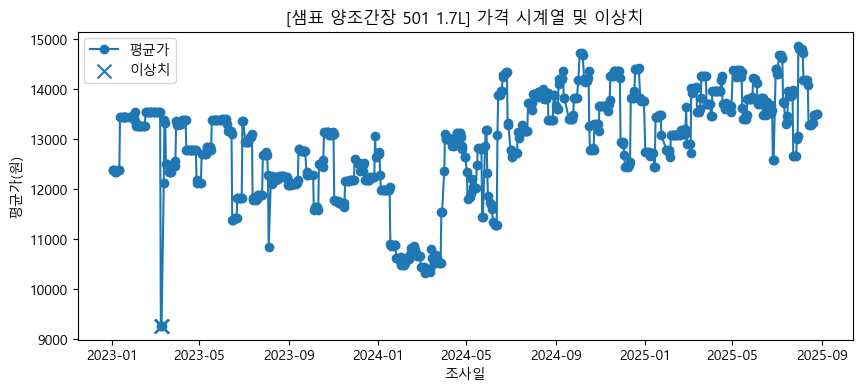

In [15]:
if target_item is not None:
    tmp = price_z[price_z["품종"] == target_item].sort_values("조사일")

    plt.figure(figsize=(10,4))
    plt.plot(tmp["조사일"], tmp["평균가"], marker="o", label="평균가")
    anom_points = tmp[tmp["z_price"].abs() > 3]
    plt.scatter(anom_points["조사일"], anom_points["평균가"],
                marker="x", s=100, label="이상치")
    plt.title(f"[{target_item}] 가격 시계열 및 이상치")
    plt.xlabel("조사일")
    plt.ylabel("평균가(원)")
    plt.legend()
    plt.show()
else:
    print("가격 이상치가 없어 시각화할 대상이 없습니다.")


In [16]:
# 품종별 텍스트 이상치 결과
name_feat.to_csv("catalog_name_anomaly_result.csv", index=False, encoding="utf-8-sig")

# 시계열 기반 가격 이상치
price_anoms.to_csv("catalog_price_anomaly_result.csv", index=False, encoding="utf-8-sig")

print("저장 완료:")
print(" - catalog_name_anomaly_result.csv")
print(" - catalog_price_anomaly_result.csv")


저장 완료:
 - catalog_name_anomaly_result.csv
 - catalog_price_anomaly_result.csv
